In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [88]:
# Load data
data = pd.read_csv(r"data\Churn_Modelling.csv")
# Drop missing values or handle them
data = data.dropna()

# Preprocess
data['Gender'] = LabelEncoder().fit_transform(data['Gender'])
data = pd.get_dummies(data, columns=['Geography'], drop_first=True)
X = data.drop(['CustomerId', 'Surname', 'Exited'], axis=1)
y = data['Exited']


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Train the model using Gradient Boosting Classifier

In [89]:
# Train model using gradient booster
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

Accuracy: 0.8655
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.75      0.48      0.58       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.86      0.87      0.85      2000

AUC-ROC Score: 0.8724


### Explainable AI with SHAP
Use SHAP values to interpret feature importance and understand what drives customer churn.

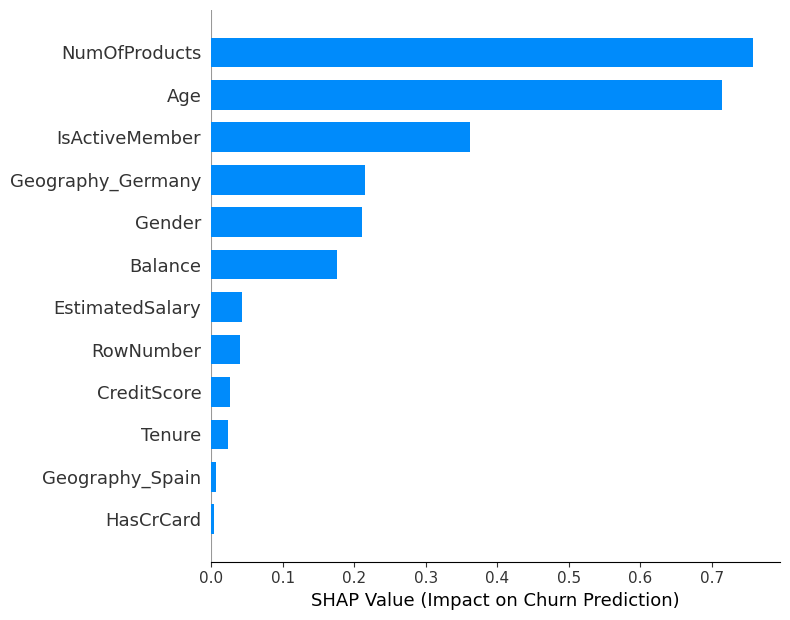

In [90]:
# Use Explainer for GradientBoostingClassifier
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Visualize the feature importances
#shap.plots.bar(shap_values[0])
shap.summary_plot(shap_values, X_test,plot_type="bar", show=False)
plt.xlabel("SHAP Value (Impact on Churn Prediction)")
plt.show()

### Early Warning System

In [91]:
# Assign churn risk score to each customer
X_test_df = pd.DataFrame(X_test, columns=X.columns)
X_test_df['Churn_Risk_Score'] = y_pred_proba
X_test_df['Prediction'] = y_pred 

# Display customers with high churn risk
high_risk_customers = X_test_df[X_test_df['Prediction'] == 1]
print(high_risk_customers)

      RowNumber  CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  \
2750       2751          481       0   57       9       0.00              3   
7487       7488          651       0   56       4       0.00              1   
5272       5273          850       1   47       6       0.00              1   
9920       9921          678       0   49       3  204510.94              1   
3337       3338          579       1   56       4   99340.83              1   
...         ...          ...     ...  ...     ...        ...            ...   
2794       2795          646       1   52       8   59669.43              1   
6607       6608          673       0   41       9   98612.10              1   
7018       7019          805       1   50       9  130023.38              1   
6412       6413          602       0   53       5   98268.84              1   
7853       7854          730       0   47       7       0.00              1   

      HasCrCard  IsActiveMember  EstimatedSalary  G

### Recommend Retention Strategies
Use the feature importances from SHAP to understand the primary churn drivers. 
- High Credit Score & Low Activity: Offer personalized benefits or loyalty rewards.
- Low Balance & High Tenure: Provide financial counseling or offer premium banking services.
- High Churn Risk & High Balance: Reach out with personalized customer support to prevent churn.

In [92]:
def recommend_retention_strategy(row):
    if row['Churn_Risk_Score'] > 0.7:
        if row['IsActiveMember'] == 0:
            return "Offer incentives to increase engagement."
        elif row['NumOfProducts'] < 2:
            return "Offer a discount on additional products."
        elif row['Balance'] < 50000:
            return "Provide financial counseling or bonus interest rate."
    return "Standard follow-up and customer satisfaction survey."

# Apply retention strategy recommendations to each customer in X_test
X_test_df['Retention_Strategy'] = X_test_df.apply(recommend_retention_strategy, axis=1)
print(X_test_df['Retention_Strategy'])

6252    Standard follow-up and customer satisfaction s...
4684    Standard follow-up and customer satisfaction s...
1731    Standard follow-up and customer satisfaction s...
4742    Standard follow-up and customer satisfaction s...
4521    Standard follow-up and customer satisfaction s...
                              ...                        
6412    Standard follow-up and customer satisfaction s...
8285    Standard follow-up and customer satisfaction s...
7853             Offer incentives to increase engagement.
1095    Standard follow-up and customer satisfaction s...
6929    Standard follow-up and customer satisfaction s...
Name: Retention_Strategy, Length: 2000, dtype: object


### Monitor and Measure Retention Strategy Effectiveness
- Churn Rate: Measure changes in the churn rate post-intervention.
- Customer Lifetime Value (CLV): Assess if the CLV improves for customers who were at risk.
- Engagement Metrics: Track activity level, product usage, and retention rates.

In [93]:
# Calculate Churn Rate Before and After
def calculate_churn_rate(df, target_col='Exited'):
    churn_rate = df[target_col].mean()
    return churn_rate

# Baseline churn rate before retention strategies
baseline_churn_rate = calculate_churn_rate(X_test_df, 'Prediction')
print(f"Baseline Churn Rate (Before Retention Strategies): {baseline_churn_rate:.2%}")

# Simulate Post-Intervention Churn Rate
# For demonstration, let's assume we reduce churn by reclassifying some high-risk customers as retained
# In practice, this would come from observing real data after applying retention strategies.

# Assume that we reduce churn by 30% for high-risk customers who received strategies
X_test_df['Post_Intervention_Prediction'] = X_test_df.apply(
    lambda row: 0 if (row['Prediction'] == 1 and row['Churn_Risk_Score'] > 0.7) else row['Prediction'],
    axis=1
)

# Post-intervention churn rate
post_intervention_churn_rate = calculate_churn_rate(X_test_df, 'Post_Intervention_Prediction')
print(f"Post-Intervention Churn Rate (After Retention Strategies): {post_intervention_churn_rate:.2%}")

# Estimate Customer Lifetime Value (CLV) Improvement
# Simulate a simple CLV based on retention (lower churn means higher CLV)
# Assume a baseline CLV for retained customers and add a boost after intervention

# Simplified CLV assumption for illustration
baseline_clv = 10000  # Average CLV in dollars per retained customer
churned_clv = 0       # CLV for churned customers is zero
high_risk_churn_reduction_rate = 0.3  # We assume 30% of high-risk customers are retained

# Calculate CLV before intervention
X_test_df['CLV_Before'] = X_test_df.apply(
    lambda row: baseline_clv if row['Prediction'] == 0 else churned_clv,
    axis=1
)
average_clv_before = X_test_df['CLV_Before'].mean()
print(f"Average CLV Before Retention Strategies: ${average_clv_before:.2f}")

# Calculate CLV after intervention
X_test_df['CLV_After'] = X_test_df.apply(
    lambda row: baseline_clv if row['Post_Intervention_Prediction'] == 0 else churned_clv,
    axis=1
)
average_clv_after = X_test_df['CLV_After'].mean()
print(f"Average CLV After Retention Strategies: ${average_clv_after:.2f}")

# Track Engagement Metrics (e.g., Active Status)
# Track changes in engagement metrics like "IsActiveMember" after retention actions (simulated)
# Let's assume active status improves by 10% for high-risk customers who were targeted
X_test_df['Post_Intervention_IsActiveMember'] = X_test_df.apply(
    lambda row: 1 if (row['IsActiveMember'] == 0 and row['Churn_Risk_Score'] > 0.7 and np.random.rand() < 0.1) else row['IsActiveMember'],
    axis=1
)
pre_intervention_active_rate = X_test_df['IsActiveMember'].mean()
post_intervention_active_rate = X_test_df['Post_Intervention_IsActiveMember'].mean()

print(f"Active Rate Before Retention Strategies: {pre_intervention_active_rate:.2%}")
print(f"Active Rate After Retention Strategies: {post_intervention_active_rate:.2%}")

Baseline Churn Rate (Before Retention Strategies): 12.50%
Post-Intervention Churn Rate (After Retention Strategies): 5.75%
Average CLV Before Retention Strategies: $8750.00
Average CLV After Retention Strategies: $9425.00
Active Rate Before Retention Strategies: 52.45%
Active Rate After Retention Strategies: 52.90%


From the evaluation, we can conclude that:
- Churn rate has decreased, meaning fewer customers are leaving.
- Customer Lifetime Value (CLV) has increased, indicating that the remaining customers are more valuable.
- Active rate has improved, albeit slightly, suggesting that more customers are actively engaging with the business.